### **Imports Made**:
- Numpy for general purpose tasks (ex: file loads, matrix operations and arrangements, etc)
- TensorFlow for the entire CNN structure and implementation, as well as a multitude of additional general purpose functions regarding machine learning and transfer learning models used like Inception V3
- sklearn.model_selection for the train test split function that allows our data split
- sklearn.linear_metrics for more precise accuracy indicators, and confusion matrix representation
- imlearn.over_sampling for the SMOTE data augmentation function (commented because it provided worse results than regular data augmentation)
- Random Set Seeds to created a deterministic environment for weight assignements and random calculations
- Keras Tuner for CNN hyperparameter determination, was especially useful in the Dropout layers values calculations

The key metric to be evaluated will be Balanced Accuracy, just as stated in the project report.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from numpy import random

np.random.seed(2)

tf.random.set_seed(57)

## **Data Extraction and Augmentation**:

Input files are loaded into variables *x*, *y* and *x_test*. The images are in vector format and require normalization which is executed in the next steps below. Then the data is split and the training data is checked for any imabalance. The imbalance is resolved thorugh a data augmentation step that equalizes the data between both classes, thus providing a balanced training set. However the validation set is intentionally left in it's original form, to avoid any tampering with the CNN's objective results. Finally the labels are passed to One-Hot encoding. It is worth noting that SMOTE was also experimented with for data augmentation, as commented below.

In [2]:

augmented_class2 = []

x = np.load("Xtrain_Classification1.npy")
y = np.load("ytrain_Classification1.npy")
x_test = np.load("Xtest_Classification1.npy")

# 255 is the biggest number any value of x can take

x = np.reshape(x,(len(x),28,28,3))

x = (x).astype('float32')/255.0

x_test = np.reshape(x_test,(len(x_test),28,28,3))

x_test = (x_test).astype('float32')/255.0

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

class1 = X_train[y_train == 0]
class2 = X_train[y_train == 1]

n_class1 = len([0 for i in range(y_train.shape[0]) if y_train[i] == 0])
n_class2 = len([0 for i in range(y_train.shape[0]) if y_train[i] == 1])

print(f'There is a {(n_class1/(n_class1 + n_class2)) * 100} proportion between classes')
print(f'There is a {(n_class2/(n_class1 + n_class2)) * 100} proportion between classes')

'''

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

X_train_balanced = np.reshape(X_train_balanced,(len(X_train_balanced),28,28,3))
X_val = np.reshape(X_val,(len(X_val),28,28,3))


plt.figure(figsize=(10, 10))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(X_train_balanced[i])
    plt.axis("off")

'''

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
])

for i in range(n_class1 - n_class2):
    random_index = np.random.randint(0, n_class2)
    augmented_image = data_augmentation(tf.expand_dims(class2[random_index], 0))
    augmented_class2.append(augmented_image)

augmented_class2 = np.vstack(augmented_class2)

X_train_balanced = np.vstack([X_train, augmented_class2])
y_train_balanced = np.concatenate([y_train, np.ones(n_class1 - n_class2)])



y_train_balanced = tf.keras.utils.to_categorical(y_train_balanced,2)
y_val = tf.keras.utils.to_categorical(y_val,2)




There is a 85.768538876674 proportion between classes
There is a 14.231461123326007 proportion between classes


## **Convolutional Neural Network**:

The model consists of a sequence of initial convolutional layers, especialized to provide and recongnize numerous patterns and features within the image, and this information is then subsequently processed and repurposed through our use of Dropout layers in between each MaxPooling2D, and finally a BatchNormalization layer in the MLP section followed by a Dropout layer of considerable intesity (0.7). Throughout testing with the CNN hyperparameter tuning this model proved to be the one most efficient in providing the least validation loss in our data, along with a relatively high batch size of 1000 that allows the stabilization of validation loss improvement while training. 100 epochs allows (in the graph plotted in the end of the section) full view of validation loss behaviours during the training process, most notably allowing the observation of plateau zones. This added with an early stopping callback implemented to return to the weights of the sequence with the lowest validation loss provides our training with a very thorough and careful approach to determine the best possible weight configuration. 

Finally after the best weight structure is assigned, the balanced accuracy of the validation set is externally calculated and it's confusion matrix is displayed.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 conv2d_26 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 conv2d_27 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 11, 11, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 9, 9, 64)          18496     
                                                      

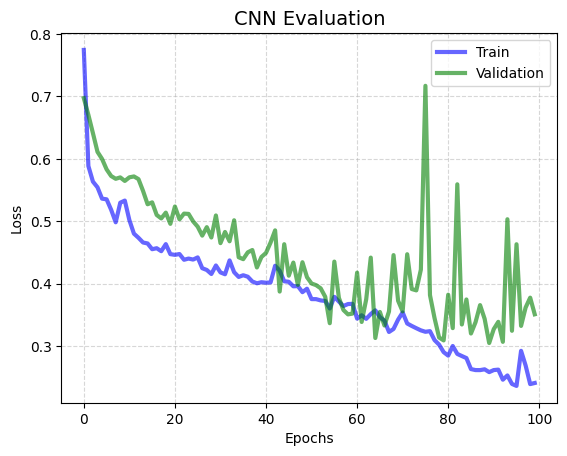

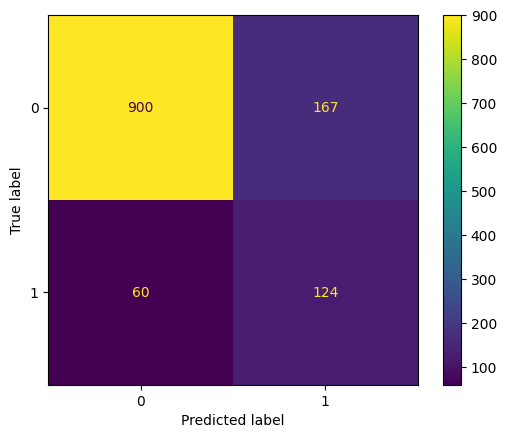

In [12]:
batch_size = 1000
lr = 0.001
epochs = 100

model_MLP = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_MLP.summary()

adam = tf.keras.optimizers.Adam(learning_rate = lr)
model_MLP.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1, restore_best_weights = True)

history = model_MLP.fit(x = X_train_balanced, y = y_train_balanced, epochs = epochs, batch_size = batch_size, validation_data = (X_val,y_val), callbacks = [early_callback])

y_pred = model_MLP.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)
model_MLP.evaluate(X_val, y_val)
y_true = np.argmax(y_val, axis = 1)
print(f'Balanced Accuracy score is {balanced_accuracy_score(y_true, y_pred)}')


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label = 'train', color = "blue", linewidth = 3, alpha = 0.6)
plt.plot(history.history['val_loss'], label = 'validation', color = "green", linewidth = 3, alpha = 0.6)
plt.xlabel(r"Epochs")
plt.ylabel(r"Loss")
plt.title(r"CNN Evaluation", fontsize = 14)
plt.legend(labels=[r'Train', r'Validation'])
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()


### **Test Prediction and Submission**:

This section includes the final test set prediction and save of the submission y_test file, as well as saving it's loss graph for later implementation for a Matlab graph (as seen in the final report).

In [ ]:
print(x_test)
print(x_test.shape)

y_test = model_MLP.predict(x_test)
y_test = np.argmax(y_test, axis = 1)


print(y_test.shape)
print(y.shape)

np.save("ytest_Classification1.npy", y_test)
np.savetxt('x.txt', history.history['loss'], fmt='%f')
np.savetxt('y.txt', history.history['val_loss'], fmt='%f')

## **SVM Image Classification**:

A second image calssification model was also tested in the form of Support Vector Classifier (SVC for short), in order to be able to provide an apt comparison to the developed CNN.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

svm_x = np.load("Xtrain_Classification1.npy")
svm_y = np.load("ytrain_Classification1.npy")

svm_X_train, svm_X_val, svm_y_train, svm_y_val = train_test_split(svm_x, svm_y, test_size = 0.2)
svm_X_train, svm_y_train = rus.fit_resample(svm_X_train, svm_y_train)

print(svm_X_train.shape, svm_y_train.shape, svm_X_val.shape, svm_y_val.shape)
unique, counts = np.unique(svm_y_train, return_counts=True)
print(dict(zip(unique, counts)))

In [7]:
from sklearn.svm import SVC


svm_classifier = SVC(kernel='linear', C=1, random_state=42)


svm_classifier.fit(svm_X_train, svm_y_train)
y_predi = svm_classifier.predict(svm_X_val)

balanced_accuracy = balanced_accuracy_score(y_test, y_predi)
print("Balanced Accuracy Score:", balanced_accuracy)

## **CNN Tuning**:

The library Keras_Tuner allows the automatization of hyperparameter determination withing a CNN, and thus provides an extremely useful method for model especialization, although very computationally demanding. Because of this it was only allowed to run sparingly, for few epochs, but it certanly provided meaningful insights on efficient parameter patterns for each layer that composed our model.

In [ ]:

from keras_tuner import Hyperband
import keras_tuner

def cnn_tuning(hp):

    model = tf.keras.models.Sequential()

    activation_function = hp.Choice("activation_function", ["relu", "tanh"])

    model.add(tf.keras.layers.Conv2D(filters=hp.Int("n_filters_1", min_value=16, max_value=32, step=16),kernel_size=(3, 3),activation=activation_function,input_shape=(28, 28, 3)))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int("n_filters_1", min_value=16, max_value=32, step=16),kernel_size=(3,3),activation=activation_function))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int("n_filters_1", min_value=16, max_value=32, step=16),kernel_size=(3,3),activation=activation_function))
    
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2))

    model.add(tf.keras.layers.Dropout(hp.Float("dropout_1", min_value=0.3, max_value=0.5, step=0.2)))

    model.add(tf.keras.layers.Conv2D(filters=hp.Int("n_filters_2", min_value=32, max_value=64, step=32),kernel_size=(3,3),activation=activation_function))
    
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2))

    model.add(tf.keras.layers.Dropout(hp.Float("dropout_2", min_value=0.05, max_value=0.3, step=0.05)))

    model.add(tf.keras.layers.Conv2D(filters=hp.Int("n_filters_3", min_value=64, max_value=128, step=64),kernel_size=(3,3),activation=activation_function))
    
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2))

    model.add(tf.keras.layers.Dropout(hp.Float("dropout_3", min_value=0.05, max_value=0.3, step=0.05)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=hp.Int("n_dense", min_value=32, max_value=64, step=32),activation=activation_function))

    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(hp.Float("dropout_3", min_value=0.3, max_value=0.8, step=0.1)))

    model.add(tf.keras.layers.Dense(units=2, activation="softmax"))

    adam = tf.keras.optimizers.Adam(learning_rate = lr)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = Hyperband(cnn_tuning, objective=keras_tuner.Objective("val_loss", direction="min"), executions_per_trial=2)

tuner.search_space_summary()
tuner.search(X_train_balanced, y_train_balanced, epochs=10, validation_data=(X_val, y_val))
chosen_hyperparams = tuner.get_best_hyperparameters(num_trials=1)


## **Transfer Learning - Inception V3**:

Finally, the last method or model employed consisted of dedicating the convolutional and feature detection section to an already established and very complex model, like Google's Inception V3. This meant that this highly efficient model could be joined with a MLP especialized to tackle our specific task and provide us with a very capable model that could perhaps yield better results. The only minor downside in this method lies in it's minimum input acceptance size: 150x150x3. The method employed to meet this demand relied on the resizing of our base images, but as our images are extremely low size (28x28x3), the resizing may have slightly compromised the feature detection employed by the model. 

2023-10-20 12:20:32.793214: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2319840000 exceeds 10% of free system memory.


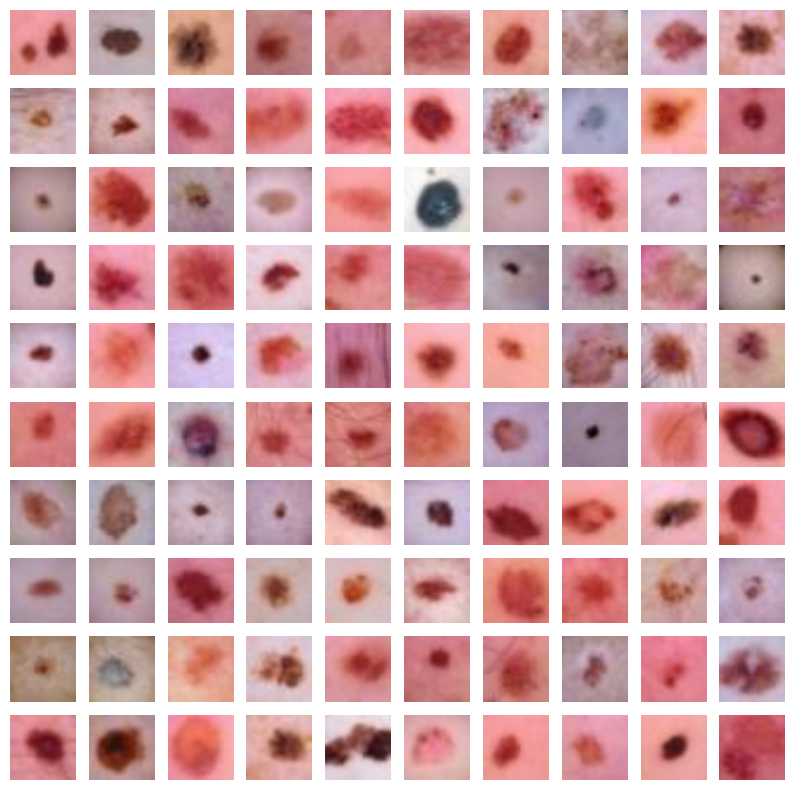

In [3]:

from tensorflow.keras.applications.inception_v3 import InceptionV3


X_train_tl = tf.image.resize(X_train_balanced, (150,150))

plt.figure(figsize=(10, 10))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(X_train_tl[i])
    plt.axis("off")
    

In [ ]:

X_val_tl = tf.image.resize(X_val, (150,150))

base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

adam = tf.keras.optimizers.Adam(learning_rate = 0.001)


model.compile(optimizer = adam, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['acc'])

early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1, restore_best_weights = True)

tl_history = model.fit(x = X_train_tl, y = y_train_balanced, validation_data = (X_val_tl,y_val), epochs = 30, batch_size = 32, callbacks = [early_callback])


In [ ]:

y_true = y_val
y_pred = model.predict(X_val_tl)
model.evaluate(X_val_tl, y_val)
print(f'Balanced Accuracy score is {balanced_accuracy_score(y_true, y_pred)}')


plt.figure(1)
plt.clf()
plt.plot(tl_history.history['loss'], label = 'train', color = "blue", linewidth = 3, alpha = 0.6)
plt.plot(tl_history.history['val_loss'], label = 'validation', color = "green", linewidth = 3, alpha = 0.6)
plt.xlabel(r"Epochs")
plt.ylabel(r"Loss")
plt.title(r"CNN Evaluation - Transfer Learning", fontsize = 14)
plt.legend(labels=[r'Train', r'Validation'])
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

cm_tl = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm_tl).plot()
